In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, AllChem, rdFingerprintGenerator, PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import DataStructs

import sascorer
from rdkit.Chem.Descriptors import qed

from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt
%matplotlib inline

In [136]:
pd.read_csv('../data/all_chemicals')[['instance_id', 'canonical_smiles']].sample(frac=0.0005).to_csv('../../random_known.csv', header=1, index=False)

In [56]:
##Adding all available filters!
##see here for instructions: https://github.com/rdkit/rdkit/pull/536

import sys
from rdkit.Chem import FilterCatalog
from rdkit.Chem.FilterCatalog import *

params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_A)
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_B)
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_C)
params.AddCatalog(FilterCatalogParams.FilterCatalogs.BRENK)
params.AddCatalog(FilterCatalogParams.FilterCatalogs.ZINC)
params.AddCatalog(FilterCatalogParams.FilterCatalogs.NIH)

catalog = FilterCatalog(params)

brenk_mask = list()
for m in tqdm(list(predicted['molecules'])):
    brenk_mask.append(catalog.HasMatch(m))

In [2]:
predicted = pd.read_csv('predicted_smiles.csv', header=None)
predicted.columns = ['instance_id', 'canonical_smiles']

true = pd.read_csv('true_smiles.csv', header=None)
true.columns = ['instance_id', 'canonical_smiles']

positive_labels = np.load('positive_labels.npy')

targetNames = pd.read_csv('../data/all_targets', header=None)
targetNames.columns=['targetName']

###Add two cannabinoid ligands that are missing from chembl:
#anandamide:
anandamide = pd.Series(dict({'instance_id':'CHEMBL15848', 
                             'canonical_smiles':'CCCCC\C=C/C\C=C/C\C=C/C\C=C/CCCC(=O)NCCO'}))
#thc:
thc = pd.Series(dict({'instance_id':'CHEMBL465', 
                      'canonical_smiles':'CCCCCc1cc(O)c2[C@@H]3C=C(C)CC[C@H]3C(C)(C)Oc2c1'}))

true = true.append(anandamide,
                  ignore_index=True)
true = true.append(thc,
                  ignore_index=True)

In [3]:
##This helps pandas to display the molecules in a dataframe properly.
PandasTools.AddMoleculeColumnToFrame(predicted,'canonical_smiles','molecules', includeFingerprints=True)
PandasTools.AddMoleculeColumnToFrame(true,'canonical_smiles','molecules')


In [4]:
#generate fingerprints of predicted ligands and known ligands:
gen_mo = rdFingerprintGenerator.GetMorganGenerator(fpSize=2048, radius=2)
predicted_fps = [gen_mo.GetFingerprint(mol) for mol in predicted['molecules']]
true_fps = [gen_mo.GetFingerprint(mol) for mol in true['molecules']]


#create a list holding the highest similarity to a known ligand.
similarities= list()
nearest_neighbour = list()
for count, mol in enumerate(predicted_fps):
    tanimoto_values = ([DataStructs.TanimotoSimilarity(mol, i) for i in true_fps])
    index_of_highest = np.argmax(tanimoto_values)
    nearest_neighbour.append(index_of_highest)
    similarities.append(tanimoto_values[index_of_highest])
    
#if you want to find the index of the nearest neighbour again later:
#predicted['nn_index'] = nearest_neighbour


#create a list holding the 'synthetic accessibility score'
#reference: https://doi.org/10.1186/1758-2946-1-8
#module code is in: https://github.com/rdkit/rdkit/tree/master/Contrib/SA_Score
sa_score = [sascorer.calculateScore(i) for i in list(predicted['molecules'])]


#create a list holding the QED drug-likeness score
#reference: https://doi.org/10.1038/nchem.1243
qeds = [qed(mol) for mol in predicted['molecules']]


#add these lists as columns to the 'predicted' pd.DataFrame
predicted['similarities']=similarities
predicted['sa_score']=sa_score
predicted['qeds']=qeds

In [86]:
##Some extra descriptors:
from rdkit.Chem import Descriptors
tpsa = [Descriptors.rdMolDescriptors.CalcTPSA(m) for m in predicted['molecules']]
logp = [Descriptors.MolLogP(m) for m in predicted['molecules']]
molwt = [Descriptors.MolWt(m) for m in predicted['molecules']]
nitro = [Descriptors.fr_nitro(m) for m in predicted['molecules']]
carbox =  [Descriptors.fr_COO(m) for m in predicted['molecules']]

predicted['tpsa']=tpsa
predicted['logp']=logp
predicted['molwt']=molwt
predicted['nitro']=nitro
predicted['carbox']=carbox

In [99]:
mask = ((predicted['tpsa']<90) & 
        (predicted['logp']<5.5) &
       (predicted['molwt']<600) &
       (predicted['nitro']<1) &
       (predicted['carbox']<1) &
       (predicted['similarities']<0.4) )

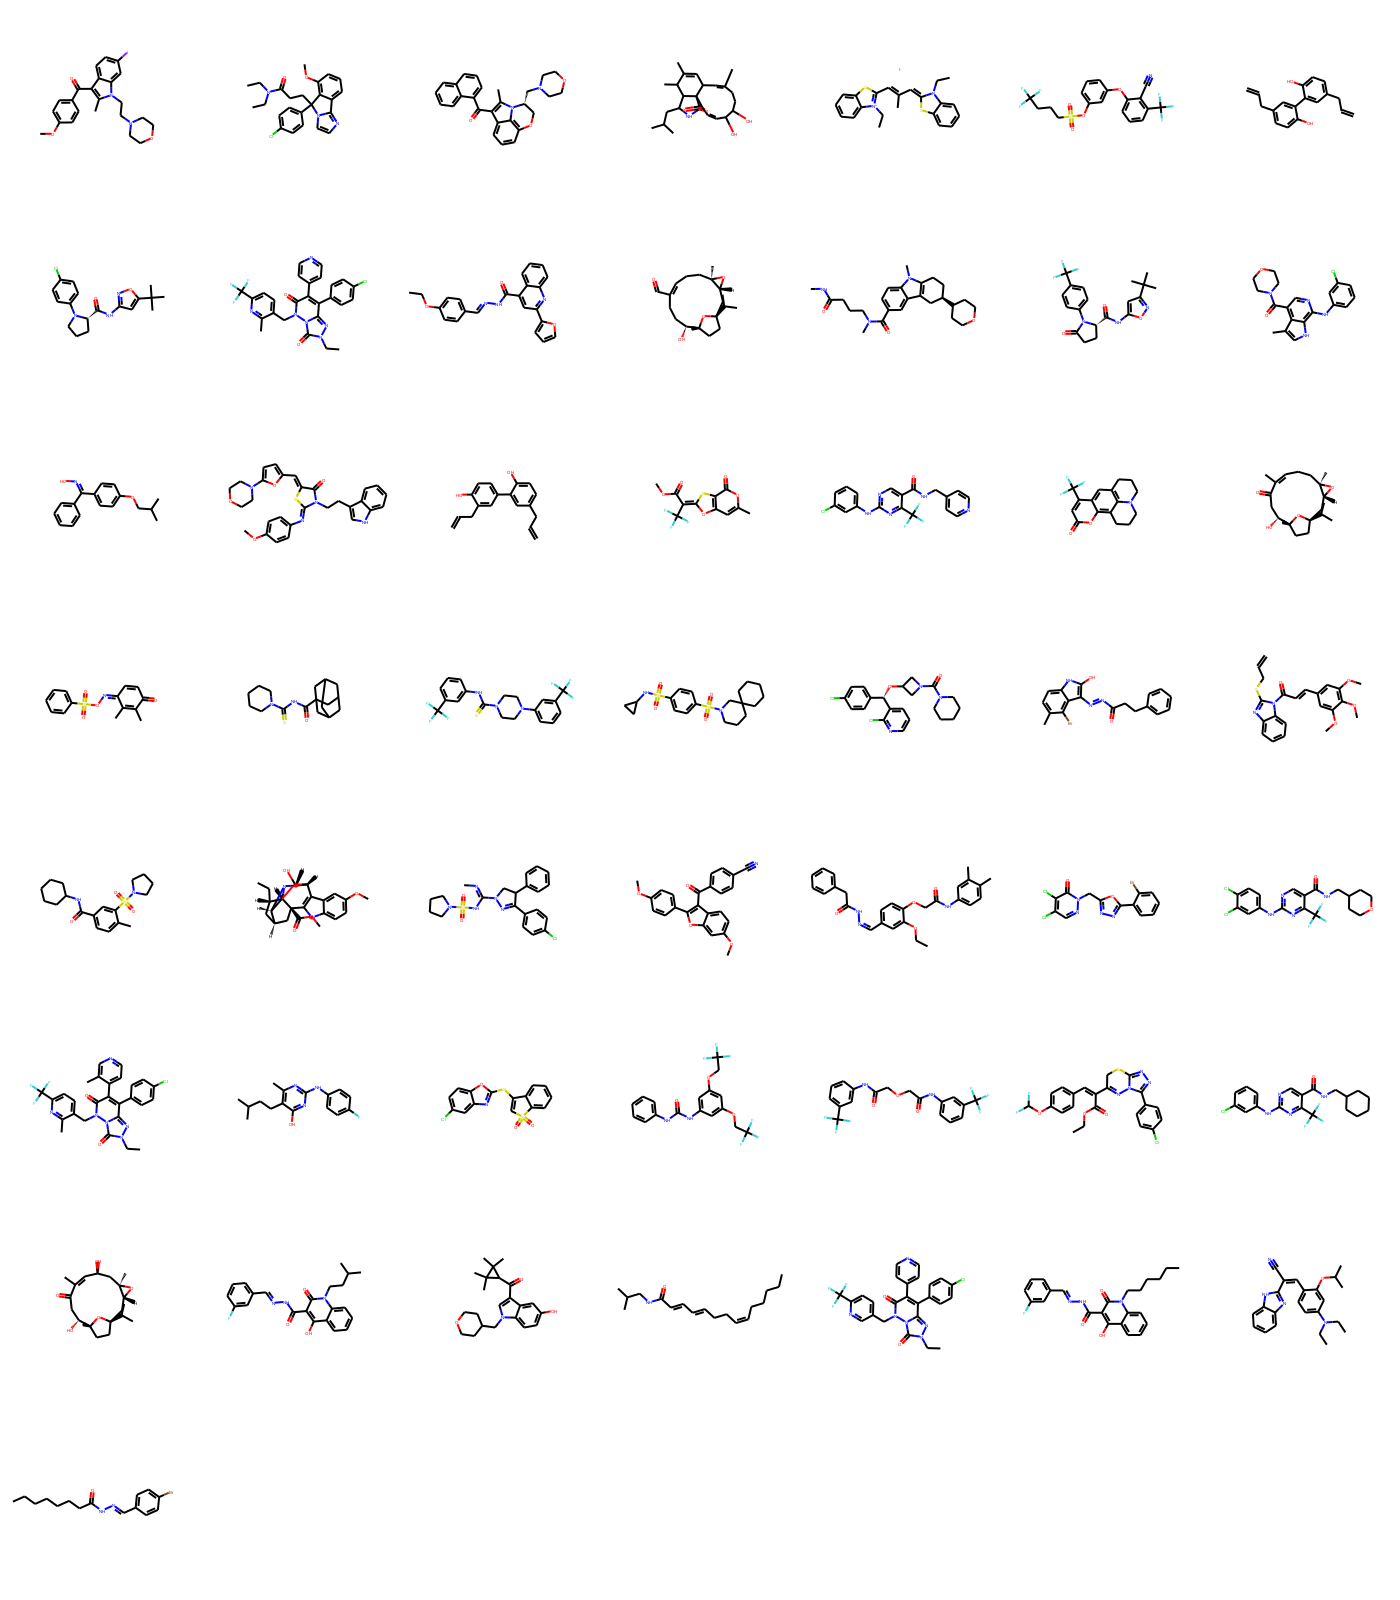

In [100]:
Draw.MolsToGridImage(predicted[mask]['molecules'], molsPerRow=7)

In [6]:
##We don't want the top predicted ligands to all have the same scaffold.
##To avoid this, we will cluster the predicted ligands and only return the 
##top-ranked instance from each cluster. 

pairwise_distances_all = pairwise_distances(np.array(predicted_fps), metric='dice')

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1575: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


In [150]:
##Filtering known actives / inactives from PubChem data:
bioassay_activities = pd.read_csv('PubChem_bioactivity_composite_query_gpr55_aids.csv')


predicted_activities = pd.read_csv('predicted_smiles_CIDs.tsv', sep='\t', header=None)
predicted_activities.columns = ['smiles', 'cid']

pubchem = predicted_activities['cid'].isin(bioassay_activities['cid'][bioassay_activities['activity'].isin(['Active', 'Inactive'])])

predicted['pubchem']=pubchem

#predicted_activities = predicted_activities[~pd.isna(predicted_activities['cid'])]
#predicted_activities['cid'] = predicted_activities['cid'].astype(int)



In [152]:
##This creates a new column with cluster labels each time. 
##This is if you want to change the cluster parameters (i.e. distance threshold)
##If not doing re-clustering, this can be removed and replace below by a single list
##of cluster labels. 
def get_cluster_ids(clusterer, shortlist_mask):
    cluster_labels = list()
    count = 0
    for idx in range(len(shortlist_mask)):
        if shortlist_mask[idx]==True:
            cluster_labels.append(clusterer.labels_[count])
            count+=1
        else:
            cluster_labels.append(None)
    return cluster_labels

@interact
def get_top_ligands(similarity=(0.2, 1,0.05), sa_score=(1,7,0.1), qeds=0.25, dist_threshold=0.6, num_mols=25):
    shortlist_mask = ((predicted['similarities']<similarity) & 
                  (predicted['sa_score']<sa_score) &
                 (predicted['qeds'] > qeds) &
                     (~np.array(brenk_mask)) &
                     (~pubchem))

    
    clusterer = AgglomerativeClustering(n_clusters=None,
                                distance_threshold=dist_threshold, 
                                affinity='precomputed', 
                                linkage='average')
    clusterer.fit(pairwise_distances_all[shortlist_mask])
    predicted['cluster_labels']=get_cluster_ids(clusterer, shortlist_mask)
    
    #return predicted[shortlist_mask].drop_duplicates(subset='cluster_labels',keep='first').iloc[:num_mols]
    return Draw.MolsToGridImage(predicted[shortlist_mask].drop_duplicates(subset='cluster_labels',keep='first')['molecules'].iloc[:num_mols],
                                maxMols=num_mols,
                               molsPerRow=6)



interactive(children=(FloatSlider(value=0.6000000000000001, description='similarity', max=1.0, min=0.2, step=0…

In [117]:
((predicted['similarities']<similarity) &
        (predicted['tpsa']<90) & 
            (predicted['logp']<5.5) &
            (predicted['molwt']<600) &
            (predicted['nitro']<1) &
            (predicted['carbox']<1) &
            (predicted['similarities']<0.4))

NameError: name 'similarity' is not defined

# Using homegrown filters:

In [120]:


@interact
def get_top_ligands(similarity=(0.23,1,0.01), tpsa=90, logp=5.5, molwt=600, num_mols=25, dist_threshold=0.6):

    shortlist_mask = ((predicted['similarities']<similarity) &
        (predicted['tpsa']<tpsa) & 
            (predicted['logp']<logp) &
            (predicted['molwt']<molwt) &
            (predicted['nitro']<1) &
            (predicted['carbox']<1) &
            (predicted['similarities']<0.4))
                #(~np.array(brenk_mask)))

    
    clusterer = AgglomerativeClustering(n_clusters=None,
                                distance_threshold=dist_threshold, 
                                affinity='precomputed', 
                                linkage='average')
    clusterer.fit(pairwise_distances_all[shortlist_mask])
    predicted['cluster_labels']=get_cluster_ids(clusterer, shortlist_mask)
    
    #return predicted[shortlist_mask].drop_duplicates(subset='cluster_labels',keep='first').iloc[:num_mols]
    return Draw.MolsToGridImage(predicted[shortlist_mask].drop_duplicates(subset='cluster_labels',keep='first')['molecules'].iloc[:num_mols],
                                maxMols=num_mols,
                               molsPerRow=6)



interactive(children=(FloatSlider(value=0.61, description='similarity', max=1.0, min=0.23, step=0.01), IntSlid…

In [22]:
arr = targetNames['targetName'].to_numpy()
#positive_labels[shortlist_mask].astype('bool')

In [23]:
[arr[i] for i in positive_labels[shortlist_mask].astype('bool')]

[array(['ATP-dependent DNA helicase Q1', 'Aldehyde dehydrogenase 1A1',
        'Cannabinoid CB1 receptor', 'Cannabinoid CB2 receptor',
        'Cytochrome P450 3A4', 'Thyroid stimulating hormone receptor'],
       dtype=object),
 array(['Cannabinoid CB1 receptor', 'Neuropeptide S receptor'],
       dtype=object),
 array(['Aldehyde dehydrogenase 1A1', 'Cannabinoid CB1 receptor',
        'Cannabinoid CB2 receptor', 'Inositol monophosphatase 1'],
       dtype=object),
 array(['ATP-dependent DNA helicase Q1', 'Cytochrome P450 1A2',
        'Cytochrome P450 2C19',
        'DNA damage-inducible transcript 3 protein',
        'G-protein coupled receptor 35',
        'Induced myeloid leukemia cell differentiation protein Mcl-1',
        'Menin/Histone-lysine N-methyltransferase MLL',
        'Nuclear receptor ROR-gamma', 'Survival motor neuron protein'],
       dtype=object),
 array(['Cannabinoid CB2 receptor', 'Cytochrome P450 2C9'], dtype=object),
 array(['Cannabinoid CB1 receptor', 'Cannabi

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:183: UserWarning: Truncating the list of molecules to be displayed to 100. Change the maxMols value to display more.
  % (maxMols))


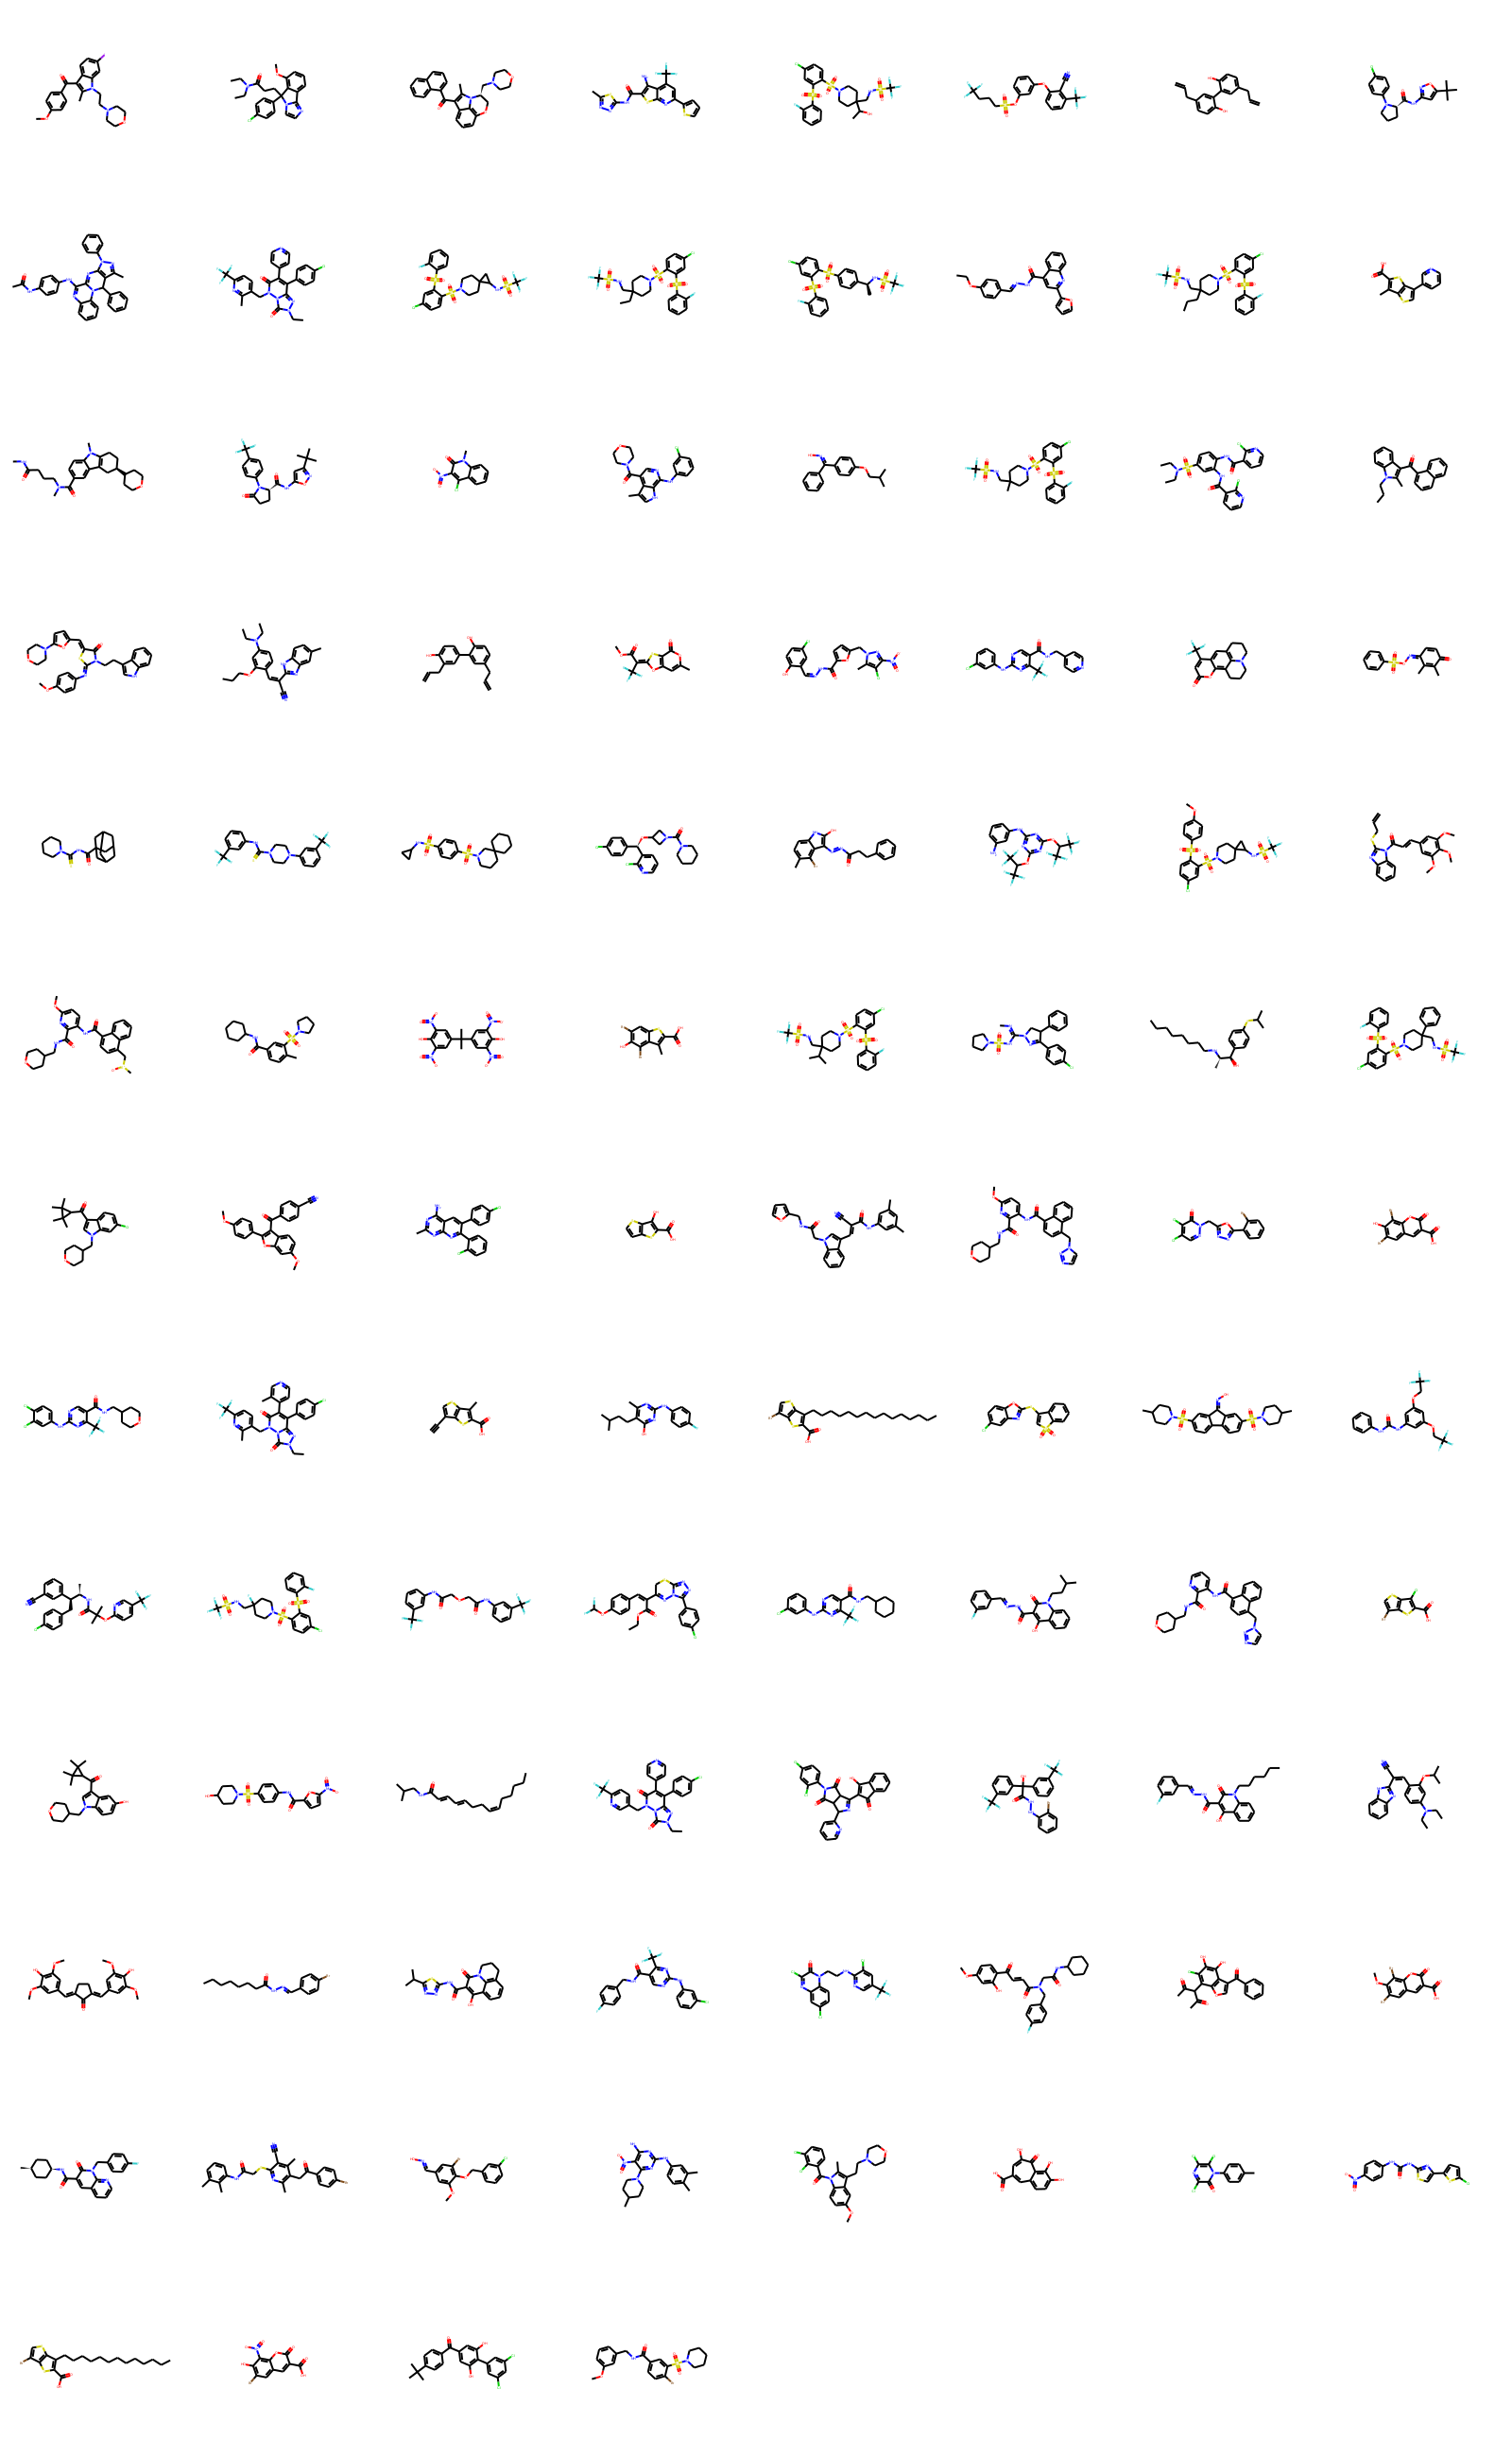

In [24]:
Draw.MolsToGridImage(list(predicted[shortlist_mask]['molecules']),
                    molsPerRow=8, maxMols=100)

In [26]:
clust = AgglomerativeClustering(n_clusters=None,
                                distance_threshold=0.6, 
                                affinity='precomputed', 
                                linkage='average')
clust.fit(pairwise_distances)

AgglomerativeClustering(affinity='precomputed', compute_full_tree='auto',
                        connectivity=None, distance_threshold=0.6,
                        linkage='average', memory=None, n_clusters=None,
                        pooling_func='deprecated')

In [27]:
cluster_labels = list()
count = 0
for idx in range(len(predicted)):
    if shortlist_mask[idx]==True:
        cluster_labels.append(clust.labels_[count])
        count+=1
    else:
        cluster_labels.append(None)

In [29]:
predicted['cluster_labels']=cluster_labels

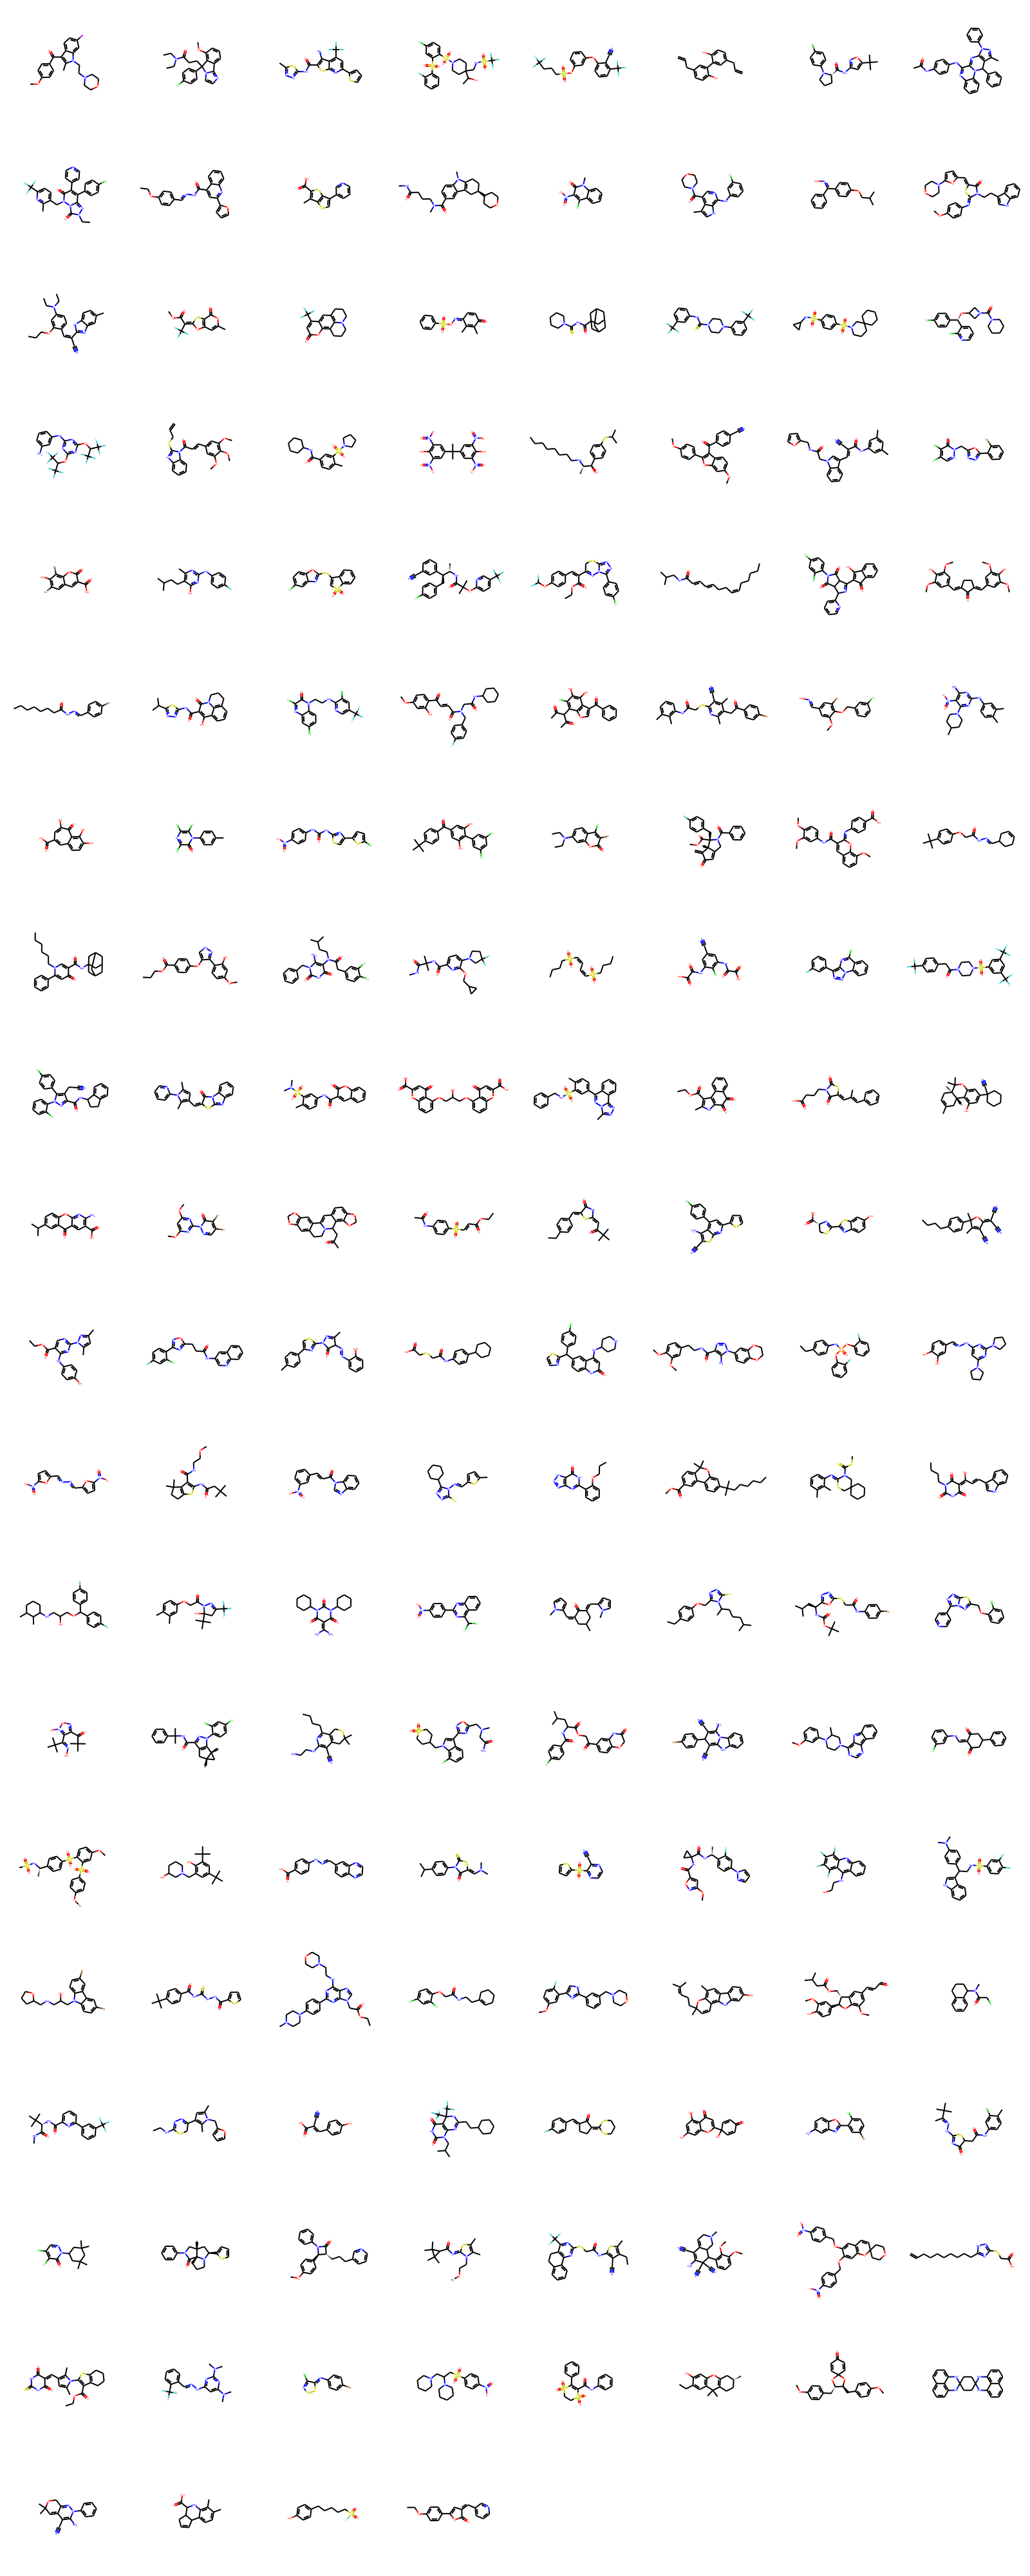

In [30]:
Draw.MolsToGridImage(predicted[shortlist_mask].drop_duplicates(subset='cluster_labels',keep='first')['molecules'],
                    molsPerRow=8,
                    maxMols=156)

In [40]:
from sklearn.metrics import pairwise_distances
pairwise_distances_all = pairwise_distances(np.array(predicted_fps), metric='dice')

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1575: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


In [79]:


def get_cluster_ids(clusterer, shortlist_mask):
    cluster_labels = list()
    count = 0
    for idx in range(len(shortlist_mask)):
        if shortlist_mask[idx]==True:
            cluster_labels.append(clusterer.labels_[count])
            count+=1
        else:
            cluster_labels.append(None)
    return cluster_labels

@interact
def get_top_ligands(similarity=0.4, sa_score=4, qeds=0.25, dist_threshold=0.6, num_mols=25):
    shortlist_mask = ((predicted['similarities']<similarity) & 
                  (predicted['sa_score']<sa_score) &
                 (predicted['qeds'] > qeds))

    
    clusterer = AgglomerativeClustering(n_clusters=None,
                                distance_threshold=dist_threshold, 
                                affinity='precomputed', 
                                linkage='average')
    clusterer.fit(pairwise_distances_all[shortlist_mask])
    predicted['cluster_labels']=get_cluster_ids(clusterer, shortlist_mask)
    
    return Draw.MolsToGridImage(predicted[shortlist_mask].drop_duplicates(subset='cluster_labels',keep='first')['molecules'].iloc[:num_mols],
                               molsPerRow=6)


interactive(children=(FloatSlider(value=0.4, description='similarity', max=1.2000000000000002, min=-0.4), IntS…

In [ ]:
df = pd.DataFrame()

df['pred_smiles']=predicted_smiles['canonical_smiles']
df['nearest_neighbour']=nearest_neighbour
df['similarities']=similarities
#
PandasTools.AddMoleculeColumnToFrame(df,'pred_smiles','pred_mol')
PandasTools.AddMoleculeColumnToFrame(df,'nearest_neighbour','nn_mol')

In [ ]:
df = df.drop('pred_smiles',axis=1)
df = df.drop('nearest_neighbour', axis=1)

In [ ]:
df = df.sort_values(by='similarities', ascending=False)

In [ ]:
df[(df['similarities']>0.2) & (df['similarities']<0.40)]

In [ ]:
##Remove near-neighbours to known positives:
shortlist = predicted_mols[(np.array(similarities)<0.4)]



#Draw.MolsToGridImage(predicted_mols[(np.array(similarities)<0.4)], molsPerRow=6)

In [ ]:
sa_scores = list()
best_shortlist = list()
for i in tqdm(shortlist):
    score = sascorer.calculateScore(i)
    if score<4:
        best_shortlist.append(i)
    #sa_scores.append(sascorer.calculateScore(i))

In [ ]:
Draw.MolsToGridImage(best_shortlist, molsPerRow=6)

In [ ]:
import networkx as nx
from rdkit.Chem import rdmolops
G = nx.from_numpy_matrix(rdmolops.GetAdjacencyMatrix(best_shortlist[0]))

In [ ]:
bigdiameters = list()
small_shortlist = list()
for mo in best_shortlist:
    G = nx.from_numpy_matrix(rdmolops.GetAdjacencyMatrix(mo))
    try:
        d = nx.diameter(G)
        if d>20:
            bigdiameters.append(mo)
        else:
            small_shortlist.append(mo)
    except:
        pass

In [ ]:
Draw.MolsToGridImage(np.random.choice(np.array(small_shortlist), 50, replace=False), molsPerRow=7)

In [ ]:
plt.plot(similarities[sorting_indices])

In [ ]:
pairs_to_draw = 40
indices = pairs_to_draw*2

sorting_indices = np.argsort(-similarities)

Draw.MolsToGridImage(mol_pairs[sorting_indices][:indices], molsPerRow=6, 
                     legends=[str(i) for i in similarities[sorting_indices][:indices]],
                    maxMols=100)


In [ ]:
mol_pairs

In [ ]:
##Next, for each set of predictions, get the ranking
##of only the unknown ligands (i.e. mask and remove the
##known true positives)

ranks_list = list()
#mask to remove the true positives:
true_pos = interaction_matrix[:,targetIndex].toarray().T[0]==1

for preds in tqdm(preds_list):
    ranks = rankdata(-preds[~true_pos])
    ranks_list.append(ranks)

##Finally, take the geometric average of the three sets of ranks:
##to get a consensus set of rank orders:
geo_ranks =np.power(ranks_list[0], 1)

#this now returns the indices that give you the top ranked ligands.
ranked_indices = geo_ranks.argsort()

In [ ]:
##Save top results:
#load all chemical smiles:
allSmiles = pd.read_csv('../data/all_chemicals')
#get top 2000 predicted unknowns
predicted_smiles = allSmiles.iloc[~true_pos].iloc[ranked_indices[:2000]][['instance_id', 'canonical_smiles']]

#and keep the smiles for the true positives as well:
true_smiles = allSmiles.iloc[true_pos][['instance_id', 'canonical_smiles']]

In [ ]:
predicted_smiles.to_csv('predicted_smiles.csv', header=0, index=False)
true_smiles.to_csv('true_smiles.csv', header=0, index=False)

In [ ]:
#test = sparse.lil_matrix((interaction_matrix.shape[0],interaction_matrix.shape[1]))
#test[:,targetIndex]=1
#test = sparse.csr_matrix(test)

In [ ]:
##This takes a while (basically lightfm is slower)

def calc_ranks_given_name(name, algo, train, test):
    if name == 'label_correlation':
        preds = algo(train)
    else:
        params = utils.read_params(name)
        preds = algo(params, train)
        for _ in range(7):
            preds += algo(params, train)
    ranks = utils.evaluate_predictions(preds, test, train)
    return ranks

filenames = ['label_correlation', 'hpo_implicit_bpr']#,
             #'hpo_lightfm_warp']

##Functions to train those algorithms:
algorithms = [utils.train_label_correlation,
                  utils.train_implicit_bpr,
                  utils.train_lightfm_warp]


preds_list = list()
ranks_list = list()
for name, algo in zip(filenames, algorithms):
        print(name)
        if name == 'label_correlation':
            preds = algo(interaction_matrix)
        else:
            params = utils.read_params(name)
            preds = algo(params, interaction_matrix)
            for _ in range(7):
                preds += algo(params, interaction_matrix)
        preds_list.append(preds[:,targetIndex])

In [ ]:
ranks_list

In [ ]:
m = (interaction_matrix[:,targetIndex].toarray()==1).flatten()

In [ ]:
across_sum = np.array(interaction_matrix.sum(axis=1)).flatten()
across_sum



In [ ]:
import copy
name = 'hpo_implicit_bpr'
pos_indices = np.logical_and(across_sum>1, m).nonzero()[0]
record_ranks =list()
for p in np.random.choice(pos_indices, 10, replace=False):
    copy_matrix = copy.copy(interaction_matrix)
    copy_matrix[p,targetIndex]=0
    

    params = utils.read_params(name)
    print('training')
    preds = algo(params, interaction_matrix)
    #for _ in tqdm_notebook(range(3)):
    #    preds += algo(params, interaction_matrix)
    print('ranking:')
    ma_preds = np.ma.masked_array(-preds[:,targetIndex], mask=copy_matrix[:,targetIndex].toarray().flatten().astype(bool))
    
    ranks = rankdata(ma_preds)
    missing_rank = ranks[p]
    print(missing_rank)
    record_ranks.append(missing_rank)
    
    

In [ ]:
name = 'hpo_implicit_bpr'
pos_indices = np.logical_and(across_sum>1, m).nonzero()[0]
record_ranks =list()
for p in np.random.choice(pos_indices, 100, replace=False):
    copy_matrix = copy.copy(interaction_matrix)
    copy_matrix[p,targetIndex]=0
    

    params = utils.read_params(name)
    print('training')
    preds = algo(params, interaction_matrix)
    #for _ in tqdm_notebook(range(3)):
    #    preds += algo(params, interaction_matrix)
    print('ranking:')
    ma_preds = np.ma.masked_array(-preds[:,targetIndex], mask=copy_matrix[:,targetIndex].toarray().flatten().astype(bool))
    
    ranks = rankdata(ma_preds)
    missing_rank = ranks[p]
    print(missing_rank)
    record_ranks.append(missing_rank)
    
    

In [ ]:
kdeplot(record_ranks)
plt.scatter(record_ranks, np.zeros(len(record_ranks)),alpha=0.5)
plt.xlim(0,100)

In [ ]:
plt.plot([(np.array(record_ranks)<i).sum()/len(record_ranks) for i in range(30)])

In [ ]:
#Trying with label corr:
preds = utils.train_label_correlation(interaction_matrix)

In [ ]:
pos_indices = np.logical_and(across_sum>1, m).nonzero()[0]
#pre = preds.toarray()
print('ranking:')
ranks = rankdata(-pre[:,targetIndex])
lc_ranks = list()


In [ ]:
name = 'hpo_implicit_bpr'
pos_indices = np.logical_and(across_sum>1, m).nonzero()[0]
#record_ranks =list()

params = utils.read_params(name)
print('training')
preds = algo(params, interaction_matrix)
print('ranking:')
ranks = rankdata(-preds[:,targetIndex])

In [ ]:
kdeplot(ranks[pos_indices])
plt.scatter(ranks[pos_indices], np.zeros(len(pos_indices)), alpha=0.5)
plt.xlim(0,150)

In [ ]:
record_ranks = ranks[pos_indices]
plt.plot([(record_ranks<i).sum() for i in range(30)])

In [ ]:
preds

In [ ]:
~copy_matrix[:,targetIndex].toarray().flatten().astype(bool)

In [ ]:
np.array([False,False,False,True,True,True])

In [ ]:
test_arr = np.array([1,1,1,2,2,2])
test_ma = np.ma.masked_array(test_arr, mask=np.array([False,False,False,True,True,True]))
print(np.mean(test_ma))#

In [ ]:
ma_preds = np.ma.masked_array(-preds[:,targetIndex], mask=~copy_matrix[:,targetIndex].toarray().flatten().astype(bool))

In [ ]:
ma_preds.data[ma_preds.mask].shape

In [ ]:
across_sum>1

In [ ]:
preds_list[0] = preds_list[0].toarray().T[0]

In [ ]:
ranks_list = list()
#mask to remove the true positives:
true_pos = interaction_matrix[:,targetIndex].toarray().T[0]==1

for preds in tqdm_notebook(preds_list):
    ranks = rankdata(-preds[~true_pos])
    ranks_list.append(ranks)

In [ ]:
allSmiles.iloc[~true_pos].iloc[ranked_indices[:1000]][['instance_id', 'canonical_smiles']]

In [ ]:
predicted_smiles.to_csv('test.csv', header=0, index=False)

In [ ]:
geo_ranks =np.power(ranks_list[0] * ranks_list[1], 1/2)
ranked_indices = geo_ranks.argsort()

In [ ]:
allSmiles =pd.read_csv('../data/all_chemicals')

predicted_smiles = allSmiles.iloc[~true_pos].iloc[ranked_indices[:1000]]['canonical_smiles']
true_smiles = allSmiles.iloc[true_pos]['canonical_smiles']


In [ ]:
predicted_mols = [Chem.MolFromSmiles(i) for i in list(predicted_smiles)]
true_mols = [Chem.MolFromSmiles(i) for i in list(true_smiles)]

In [ ]:
gen_mo = rdFingerprintGenerator.GetMorganGenerator(fpSize=1024, radius=2)
predicted_fp = [gen_mo.GetFingerprint(mol) for mol in predicted_mols]
true_fp = [gen_mo.GetFingerprint(mol) for mol in true_mols]

In [ ]:
similarities = list()
for m in predicted_fp:
    similarities.append(max([DataStructs.TanimotoSimilarity(m, i) for i in true_fp]))

In [ ]:
kdeplot(similarities)

In [ ]:
Draw.MolsToGridImage(predicted_mols, molsPerRow=6, legends=[str(i) for i in similarities[:100]], maxMols=100)

In [ ]:
indices = np.random.choice(len(true_mols), 50)
Draw.MolsToGridImage(np.array(true_mols)[indices], 
                     molsPerRow=6, 
                     legends=list(np.array([str(i) for i in similarities])[indices]), 
                     maxMols=100)

In [ ]:
allSmiles =pd.read_csv('../data/all_chemicals')

predicted_smiles = allSmiles.iloc[~true_pos].iloc[ranked_indices[:1000]]['canonical_smiles']
true_smiles = allSmiles.iloc[true_pos]['canonical_smiles']

In [ ]:
predicted_mols = [Chem.MolFromSmiles(i) for i in list(predicted_smiles)]
true_mols = [Chem.MolFromSmiles(i) for i in list(true_smiles)]



In [ ]:
indo = Chem.MolFromSmiles('CC1=C(C2=C(N1C(=O)C3=CC=C(C=C3)Cl)C=CC(=C2)OC)CC(=O)O')
indo_fp = gen_mo.GetFingerprint(indo)
indo_similarity = [DataStructs.TanimotoSimilarity(fp, indo_fp) for fp in predicted_fp]


In [ ]:
predicted_mols[np.argmax(indo_similarity)]

In [ ]:
gen_mo = rdFingerprintGenerator.GetMorganGenerator(fpSize=1024, radius=2)
predicted_fp = list()
for mol in predicted_mols:
    try:
        predicted_fp.append(gen_mo.GetFingerprint(mol)) 
    except:
        pass
    
true_fp= [gen_mo.GetFingerprint(mol) for mol in true_mols]

In [ ]:
similarities = list()
for m in tqdm_notebook(predicted_fp):
    similarities.append(max([DataStructs.TanimotoSimilarity(m, i) for i in true_fp]))